In [1]:
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)

In [3]:
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [4]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_default.columns=['defaultNo','defaultYes']
df_student.columns=['studentNo','studentYes']
df_final = pd.concat([df[['balance','income']],df_default,df_student],axis=1)

In [5]:
df_final.head()

,balance,income,defaultNo,defaultYes,studentNo,studentYes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

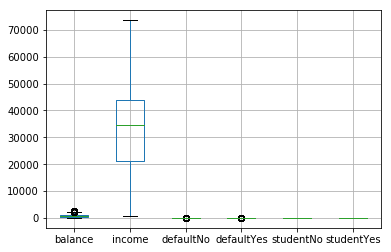

In [6]:
df_final.boxplot()

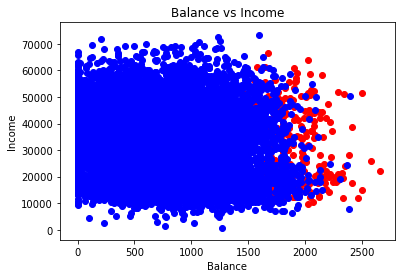

In [7]:
import pylab as plt
plt.title('Balance vs Income')
df_default = df_final[df_final['defaultYes']==1]
df_non_default = df_final[df_final['defaultNo']==1]
plt.scatter(df_default['balance'],df_default['income'],color='red')
plt.scatter(df_non_default['balance'],df_non_default['income'],color='blue')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.figure()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [8]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler

y = df_final['defaultYes'].copy()
X = df_final[['balance','income']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,title,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC with %s Penalty' %title)
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve : 0.958863


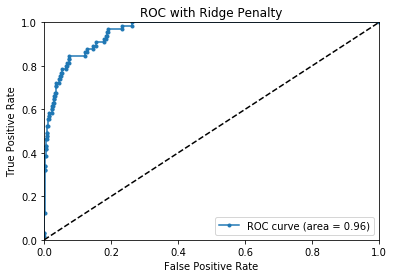

In [10]:
fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=.1,penalty='l2')
generate_ROCplot(fpr, tpr, 'Ridge', roc_auc)

Area under the ROC curve : 0.958935


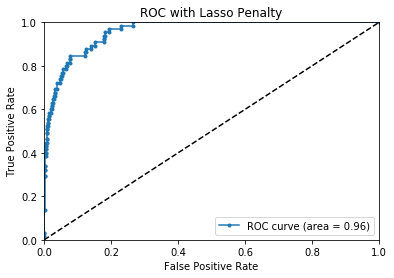

In [11]:
fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=.1,penalty='l1')
generate_ROCplot(fpr, tpr, 'Lasso', roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [12]:
X2 = df_final[['balance','income','studentYes']].copy()
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

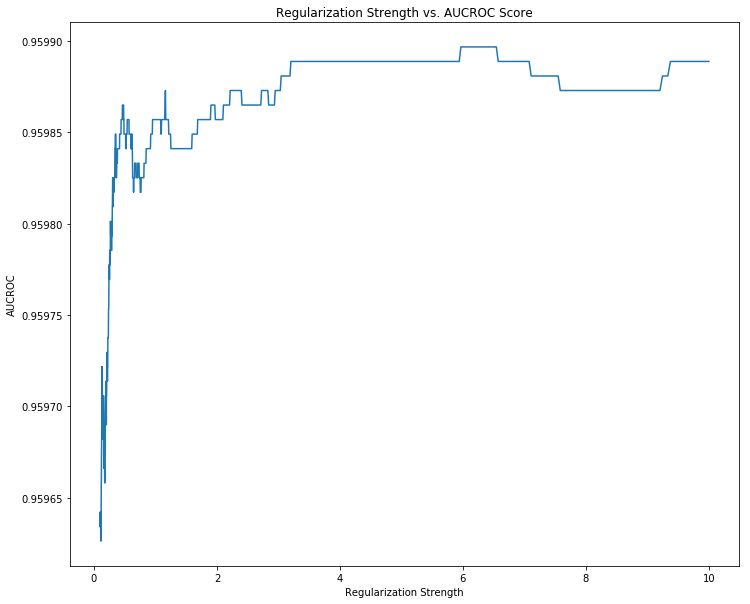

In [13]:
scores = []
random_state = np.random.RandomState(0)
X2, y = shuffle(X2, y, random_state=random_state)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
alphas = np.logspace(-1,1,1000)
for alpha in alphas:
    regr = LogisticRegression(penalty='l2',C=alpha)
    probas_ = regr.fit(X2_train, y_train).predict_proba(X2_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    scores.append(roc_auc)
plt.figure(figsize=(12,10))
plt.title('Regularization Strength vs. AUCROC Score')
plt.xlabel('Regularization Strength')
plt.ylabel('AUCROC')
plt.plot(alphas,scores)

In [14]:
best_alpha = np.argmax(scores)
# regularization score that optimizes R^2
print("Regularization strength to optimize AUCROC:",alphas[best_alpha])
print("Optimized AUCROC:", scores[best_alpha])

Regularization strength to optimize AUCROC: 5.96727119597
Optimized AUCROC: 0.959896640827


6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 